In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from scipy.sparse import lil_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("data/clean_data/recipes_cleaned.csv")
df.head()

,name_x,nutrition,n_steps,ingredients_y,minutes
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",55
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",30
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",130
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",45
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",190


## Pré-traitement des ingrédients

La colonne `ingredients_y` est stockée en chaîne (string) — on la convertit en `list` via `ast.literal_eval`.  


In [3]:
# Parser la colonne ingredients_y
# Vérifier si c'est une string ou déjà une liste
print(f"\nType de ingredients_y : {type(df['ingredients_y'].iloc[0])}")
print(f"Exemple : {df['ingredients_y'].iloc[0]}")

# Si c'est une string (ex: "['salt', 'pepper']"), parser en liste
if isinstance(df['ingredients_y'].iloc[0], str):
    print("Parsing ingredients_y de string vers list...")
    df['ingredients_y'] = df['ingredients_y'].apply(ast.literal_eval)


Type de ingredients_y : <class 'str'>
Exemple : ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Parsing ingredients_y de string vers list...


In [4]:
# Construire le vocabulaire d'ingrédients
all_ingredients = []
for ing_list in df['ingredients_y']:
    # Dédupliquer dans chaque recette
    all_ingredients.extend(set(ing_list))

unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n = len(unique_ingredients)

print(f"  Nombre de recettes : {len(df)}")
print(f"  Ingrédients uniques : {n}")

  Nombre de recettes : 222705
  Ingrédients uniques : 14621


Statistiques sur le nombre d'ingrédients uniques par recette :
     Moyenne: 9.1
     Médiane: 9.0
  Écart-type: 3.7
         Min: 1
         Max: 43
    Q1 (25%): 6.0
    Q3 (75%): 11.0


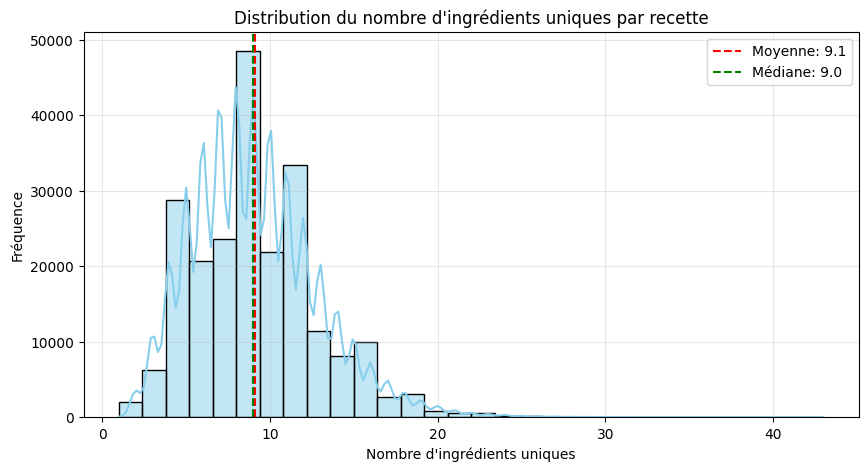

In [5]:
# Calcul du nombre d'ingrédients uniques par recette
ing_per_recipe = df['ingredients_y'].apply(lambda x: len(set(x)) if isinstance(x, list) else 0)


stats = {
    "Moyenne": ing_per_recipe.mean(),
    "Médiane": ing_per_recipe.median(),
    "Écart-type": ing_per_recipe.std(),
    "Min": ing_per_recipe.min(),
    "Max": ing_per_recipe.max(),
    "Q1 (25%)": ing_per_recipe.quantile(0.25),
    "Q3 (75%)": ing_per_recipe.quantile(0.75),
}

# Affichage des statistiques
print("Statistiques sur le nombre d'ingrédients uniques par recette :")
for k, v in stats.items():
    print(f"{k:>12}: {v:.1f}" if isinstance(v, float) else f"{k:>12}: {v}")

# 4. Visualisation de la distribution
plt.figure(figsize=(10, 5))
sns.histplot(ing_per_recipe, bins=30, kde=True, color='skyblue')
plt.axvline(ing_per_recipe.mean(), color='red', linestyle='--', label=f"Moyenne: {stats['Moyenne']:.1f}")
plt.axvline(ing_per_recipe.median(), color='green', linestyle='--', label=f"Médiane: {stats['Médiane']:.1f}")
plt.title("Distribution du nombre d'ingrédients uniques par recette")
plt.xlabel("Nombre d'ingrédients uniques")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Construire matrice binaire recettes × ingrédients
# Cette méthode est la plus robuste
n_recipes = len(df)
X = lil_matrix((n_recipes, n), dtype=bool)

for r, ing_list in enumerate(df['ingredients_y']):
    unique_in_recipe = set(ing_list)  # dédupliquer
    for ing in unique_in_recipe:
        X[r, ingredients_index[ing]] = True

# Convertir en CSR pour calculs efficaces
X = X.tocsr()

print(f"  Matrice X : {X.shape}, densité={X.nnz / (X.shape[0] * X.shape[1]):.4f}")

  Matrice X : (222705, 14621), densité=0.0006



 Fréquences des ingrédients :
  Min : 1
  Max : 83152
  Médiane : 5
  Total : 2028585

 Top 10 ingrédients les plus fréquents :
  salt: 83152 recettes
  butter: 53656 recettes
  sugar: 42544 recettes
  onion: 38174 recettes
  water: 33416 recettes
  eggs: 33226 recettes
  olive oil: 32138 recettes
  flour: 25676 recettes
  garlic cloves: 25147 recettes
  milk: 24854 recettes


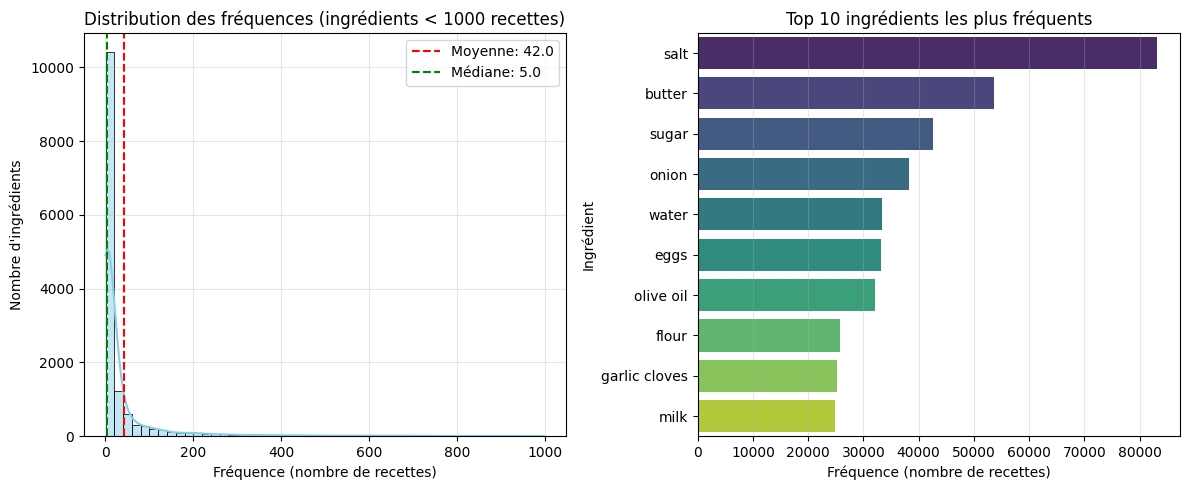

In [ ]:
# Calculer fréquences et vérifier cohérence 
deg = np.array(X.sum(axis=0)).flatten()  # somme par colonne = fréquence ingrédient

print(f"\n Fréquences des ingrédients :")
print(f"  Min : {deg.min()}")
print(f"  Max : {deg.max()}")
print(f"  Médiane : {np.median(deg):.0f}")
print(f"  Total : {deg.sum()}")

# Top 10 ingrédients
top10_idx = np.argsort(deg)[-10:][::-1]
print(f"\n Top 10 ingrédients les plus fréquents :")
for idx in top10_idx:
    print(f"  {unique_ingredients[idx]}: {deg[idx]} recettes")



# --- Plot des fréquences ---
plt.figure(figsize=(12, 5))


# --- Histogramme des fréquences (sans échelle log) ---

# Filtrer les ingrédients avec une fréquence < 1000 pour mieux voir la distribution
filtered_deg = deg[deg < 1000]

plt.subplot(1, 2, 1)
sns.histplot(filtered_deg, bins=50, color='skyblue', kde=True)
plt.axvline(filtered_deg.mean(), color='red', linestyle='--', label=f"Moyenne: {filtered_deg.mean():.1f}")
plt.axvline(np.median(filtered_deg), color='green', linestyle='--', label=f"Médiane: {np.median(filtered_deg):.1f}")
plt.title("Distribution des fréquences (ingrédients < 1000 recettes)")
plt.xlabel("Fréquence (nombre de recettes)")
plt.ylabel("Nombre d'ingrédients")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Top 10 ingrédients (barplot)
top10_names = [unique_ingredients[idx] for idx in top10_idx]
top10_values = deg[top10_idx]

plt.subplot(1, 2, 2)
sns.barplot(x=top10_values, y=top10_names, palette='viridis', hue=top10_names, legend=False)
plt.title("Top 10 ingrédients les plus fréquents")
plt.xlabel("Fréquence (nombre de recettes)")
plt.ylabel("Ingrédient")
plt.grid(True, axis='x', alpha=0.3)


plt.tight_layout()
plt.show()


In [8]:
# --- ÉTAPE 7 (version rapide avec Cosine Distance) ---
from sklearn.metrics.pairwise import cosine_distances
import time, numpy as np

print("\n Calcul de la matrice de distances Cosine (approximation Jaccard)...")

start = time.time()

X_ingredients = X.T  # ingrédients × recettes
distance_matrix = cosine_distances(X_ingredients)  # beaucoup plus rapide

print(f"  Matrice de distances : {distance_matrix.shape}")
print(f"  Min distance : {distance_matrix.min():.4f}")
print(f"  Max distance : {distance_matrix.max():.4f}")
print(f"  Symétrique : {np.allclose(distance_matrix, distance_matrix.T)}")
print(f"✅ Calcul terminé en {(time.time()-start)/60:.2f} min")

np.save("data/distance_matrix_cosine.npy", distance_matrix)



 Calcul de la matrice de distances Cosine (approximation Jaccard)...
  Matrice de distances : (14621, 14621)
  Min distance : 0.0000
  Max distance : 1.0000
  Symétrique : True
✅ Calcul terminé en 0.10 min


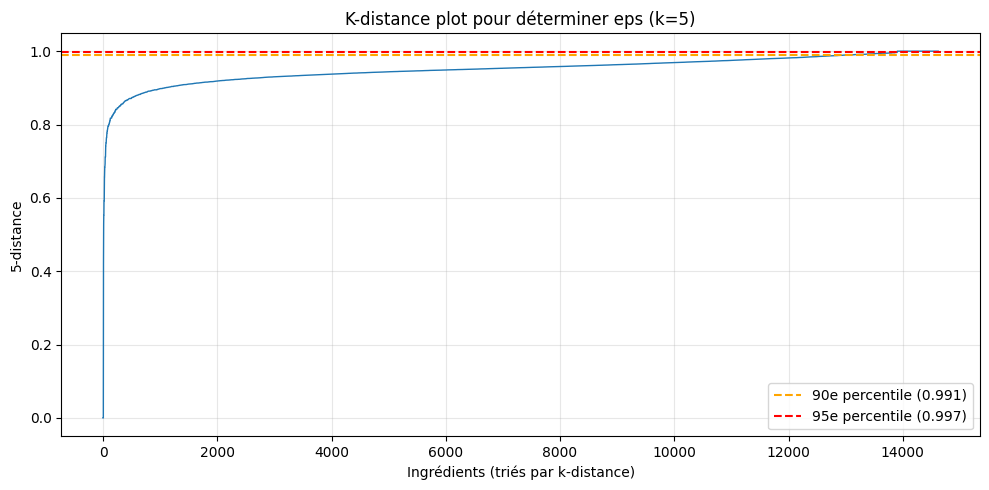


 Suggestions eps :
  90e percentile : 0.991
  95e percentile : 0.997


In [ ]:
# Choisir eps via k-distance plot 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


k = 5  # min_samples
nbrs = NearestNeighbors(n_neighbors=k+1, metric='precomputed').fit(distance_matrix)
distances, indices = nbrs.kneighbors(distance_matrix)
kdist = np.sort(distances[:, k])  # k-ième voisin (exclut soi-même)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(kdist, linewidth=1)
plt.xlabel('Ingrédients (triés par k-distance)')
plt.ylabel(f'{k}-distance')
plt.title(f'K-distance plot pour déterminer eps (k={k})')
plt.grid(True, alpha=0.3)

# Suggérer eps au 90e percentile comme départ
eps_90 = np.percentile(kdist, 90)
eps_95 = np.percentile(kdist, 95)

plt.axhline(y=eps_90, color='orange', linestyle='--', label=f'90e percentile ({eps_90:.3f})')
plt.axhline(y=eps_95, color='red', linestyle='--', label=f'95e percentile ({eps_95:.3f})')
plt.legend()
plt.tight_layout()
plt.savefig('kdistance_plot.png', dpi=150)
plt.show()

print(f"\n Suggestions eps :")
print(f"  90e percentile : {eps_90:.3f}")
print(f"  95e percentile : {eps_95:.3f}")


In [18]:
for eps in [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.991, 0.997]:
    db = DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(distance_matrix)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    noise = np.sum(db.labels_ == -1)
    print(f"eps={eps:.3f} → clusters={n_clusters}, noise={noise}")


eps=0.500 → clusters=6, noise=14587
eps=0.600 → clusters=11, noise=14547
eps=0.700 → clusters=29, noise=14441
eps=0.750 → clusters=52, noise=14283
eps=0.800 → clusters=108, noise=13863
eps=0.850 → clusters=195, noise=12740
eps=0.900 → clusters=274, noise=9264
eps=0.950 → clusters=25, noise=1316
eps=0.991 → clusters=1, noise=25
eps=0.997 → clusters=1, noise=0


In [19]:
# Run DBSCAN with eps=0.85
db = DBSCAN(eps=0.80, min_samples=10, metric='precomputed').fit(distance_matrix)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Clusters found: {n_clusters}")

# Utiliser unique_ingredients déjà défini
clusters = defaultdict(list)
for ing, label in zip(unique_ingredients, labels):
    clusters[label].append(ing)

# Afficher quelques exemples par cluster
for k, v in clusters.items():
    if k == -1:
        print(f"\nNoise ({len(v)} ingrédients isolés):")
    else:
        print(f"\nCluster {k} ({len(v)} ingrédients): {', '.join(v[:10])} ...")


Clusters found: 3

Noise (14570 ingrédients isolés):

Cluster 0 (28 ingrédients): all-purpose flour, baking powder, baking soda, black pepper, brown sugar, butter, buttermilk, cinnamon, clove, egg ...

Cluster 2 (10 ingrédients): butter toffee peanuts, caramel corn, chocolate turtle chex mix, cinnamon goldfish graham snacks, fun-size nestle crunch bars, gummy bears, miniature candy canes, miniature oreo cookie, pretzel rings, teddy grahams honey graham snacks ...

Cluster 1 (13 ingrédients): crisco%26reg%3b all-vegetable shortening sticks, crisco%26reg%3b baking sticks all-vegetable shortening, crisco%26reg%3b baking sticks butter flavor all-vegetable shortening, crisco%26reg%3b original no-stick cooking spray, double crust classic crisco pie crust, jif%26reg%3b extra crunchy peanut butter, pillsbury best%26reg%3b all purpose flour, pillsbury%26reg%3b sugar cookie mix, smucker%27s%26reg%3b caramel flavored topping, smucker%27s%26reg%3b orchard%27s finest%26reg%3b coastal valley peach a

In [20]:
clusters = defaultdict(list)
for ing, label in zip(unique_ingredients, labels):
    clusters[label].append(ing)

# Afficher les 5 plus grands clusters
for k, v in sorted(clusters.items(), key=lambda x: -len(x[1]))[:6]:
    if k == -1:
        print(f"\nNoise ({len(v)} ingrédients): {', '.join(v[:10])}")
    else:
        print(f"\nCluster {k} ({len(v)} ingrédients): {', '.join(v[:10])}")



Noise (14570 ingrédients): , 1%25 fat buttermilk, 1%25 fat cottage cheese, 1%25 low-fat chocolate milk, 1%25 low-fat milk, 10 bean soup mix, 10 inch low-fat flour tortillas, 10%25 cream, 10-inch  deep dish pie crust, 10-inch baked pie shells

Cluster 0 (28 ingrédients): all-purpose flour, baking powder, baking soda, black pepper, brown sugar, butter, buttermilk, cinnamon, clove, egg

Cluster 1 (13 ingrédients): crisco%26reg%3b all-vegetable shortening sticks, crisco%26reg%3b baking sticks all-vegetable shortening, crisco%26reg%3b baking sticks butter flavor all-vegetable shortening, crisco%26reg%3b original no-stick cooking spray, double crust classic crisco pie crust, jif%26reg%3b extra crunchy peanut butter, pillsbury best%26reg%3b all purpose flour, pillsbury%26reg%3b sugar cookie mix, smucker%27s%26reg%3b caramel flavored topping, smucker%27s%26reg%3b orchard%27s finest%26reg%3b coastal valley peach apricot preserves

Cluster 2 (10 ingrédients): butter toffee peanuts, caramel corn